In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import re
import datetime 


def process_index(fgIndex):
    
    
    
    fgIndex = fgIndex.drop(['index'], axis = 1)   
    fgIndex['date'] = pd.to_datetime(fgIndex['date'])
    fgIndex['date'] = fgIndex['date'].dt.date
    fgIndex = fgIndex.sort_values(by='date')
    fgIndex = fgIndex.reset_index(level = None, drop = True)
    fgIndex.fear[fgIndex.fear== 'Extreme Greed'] = 0
    fgIndex.fear[fgIndex.fear== 'Greed'] = 1
    fgIndex.fear[fgIndex.fear== 'Neutral'] = 2
    fgIndex.fear[fgIndex.fear== 'Fear'] = 3
    fgIndex.fear[fgIndex.fear== 'Extreme Fear'] = 4
    fgIndex["fear"] = pd.to_numeric(fgIndex["fear"])
    
    return fgIndex



In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
import datetime 
import sys
import datetime as dt
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV,train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import ConfusionMatrixDisplay

# Input: Takes in dataframe of 'coin_Bitcoin.csv' or other related coin datasets
# Output: A dataframe with added labels for increasing/not increasing
def create_labels(df):
    df['NextClose'] = df['Close'].shift(-1)
    df.loc[df['NextClose'] > df['Close'], 'Change'] = 'Increase'
    df.loc[df['NextClose'] <= df['Close'], 'Change'] = 'No Increase'
    df = df.dropna()
    df = df.drop('NextClose', axis=1)
    
    vals = df.groupby('Change').count()
    ratio = vals.loc['Increase']['SNo'] / (vals.loc['Increase']['SNo'] + vals.loc['No Increase']['SNo'])
    
    # Show the ratio of Increase to No Increase rows. This will indicate if the dataset is inbalanced 
    # if it far from a 50/50 split
    print(ratio, 1-ratio)
    
    df.Change[df.Change == 'Increase'] = 1
    df.Change[df.Change == 'No Increase'] = 0
    df["Change"] = pd.to_numeric(df["Change"])
    
    return df

# Input: Takes in dataframe with column 'date
# Output: Turns the date column into datetime object 
def process_date(df):
    df['date' ]= pd.to_datetime(df['date'], errors='coerce').dt.date
    return df

# Input: Dataframe from the currency (eg. coin_Bitcoin.csv) datasets
# Output: removes unused columns and sets index to date
def process_currency(df):
    bit_info = df.drop(['SNo', 'Name', 'Symbol'], axis=1)
    bit_info = bit_info.rename(columns={'Date': 'date'})
    bit_info['date'] = pd.to_datetime(bit_info['date']).dt.date
    return bit_info
    

# Input: Two dataframes with 'date' column
# Output: The result of merging the two dataframes
def merge_on_date(df1, df2):
    merging = df1.merge(df2, on='date')
    return merging

def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy, predictions

# Input: A dataframe post merging, an output DIRECTORY
# Output: runs random forest regression to predict closing price

# HyperParameter tuning found at:
# https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
def random_forest_regression(df, out_dir):
    
    X = df.drop(['High', 'Low', 'Close', 'Open', 'Change'], axis=1)
    X = X.drop(['Marketcap'], axis=1)
    # X = X.drop(['Volume'], axis=1)
    
    y = df.Close
    dates = df.date
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20)
    
    train_dates = X_train.date
    valid_dates = X_valid.date
    
    X_train = X_train.drop('date', axis=1)
    X_valid = X_valid.drop('date', axis=1)
    
    # HyperParameter tuning
    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 100)]
    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(2, 30, num = 2)]
    max_depth.append(None)
    # Minimum number of samples required to split a node
    min_samples_split = [2, 3, 4, 5, 10]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4, 8]
    # Method of selecting samples for training each tree
    bootstrap = [True, False]
    # Create the random grid
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}

#     estimators = 300
#     depth = 7
#     split = 50
#     model = make_pipeline(
#             StandardScaler(),
#             RandomForestRegressor(n_estimators=estimators,
#             max_depth=depth , min_samples_split=split, min_samples_leaf=15)
#         )
#     model.fit(X_train, y_train)

#     pipe = make_pipeline(
#                 StandardScaler(),
#                 RandomForestRegressor()
#             )

    rf = RandomForestRegressor()
    model = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
                                   n_iter = 30, cv = 3, verbose=3, random_state=42, n_jobs = -1)
    
    model.fit(X_train, y_train)
    
    
    base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
    base_model.fit(X_train, y_train)
    base_accuracy, predictions = evaluate(base_model, X_valid, y_valid)
    
    best_random = model.best_estimator_
    random_accuracy, predictions = evaluate(best_random, X_valid, y_valid)
    
    print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

    print('Evaluator Accuracy = %.5g' % (base_accuracy))
    print('valid data score=%.5g' % (model.score(X_valid, y_valid)))
    print('training data score=%.5g' % (model.score(X_train, y_train)))

    plt.figure(figsize=(16, 10))
    plt.scatter(dates, y, label = "Actual Price")
    plt.plot(valid_dates, model.predict(X_valid), 'r.', label = "Predicted Price")
    plt.legend(loc = "upper left")
    plt.show()
    #plt.savefig('{}/model_rfr.png'.format(out_dir))
    print(model.best_params_)
    
    return model.best_params_, base_accuracy





In [123]:

    
def main():
    
    # To run:
    # create output directory for .png images
    
    # python3 Model.py coin_Bitcoin.csv DailyAverages.csv output
    # OR
    # python3 Model.py coin_Bitcoin.csv DailySum.csv output
    
    # for now we are just merging two datasets
    # in_dir1 = sys.argv[1] # coin_Bitcoin.csv (or other currency datasets)
    # in_dir2 = sys.argv[2] # one of (DailyAverages.csv, DailySum.csv)
    # out_dir = sys.argv[3] # folder to save images
    
    in_dir1 = 'coin_Bitcoin.csv'
    in_dir2 = 'DailyAverages.csv'
    out_dir = 'Images'
    
    
    df_bitcoin = pd.read_csv(in_dir1, parse_dates=['Date'])
    df_reddit = pd.read_csv(in_dir2, parse_dates=['date'])
    
    # Pre processing for coin_Bitcoin.csv (or other currency datasets)
    df_bitcoin = create_labels(df_bitcoin)
    df_bitcoin = process_currency(df_bitcoin)
    df_bitcoin = process_date(df_bitcoin)
    
    # Pre processing for one of (DailyAverages.csv, DailySum.csv)
    df_reddit = process_date(df_reddit)
    
    #Merging df_bitcoin and fearGreedIndex
    df_index = data_extract()
    df_index = process_index(df_index)
    
    #merged = merge_on_date(df_bitcoin, df_reddit);
    merged = merge_on_date(df_bitcoin, df_reddit);
    pd.set_option('display.max_rows', 10)
    pd.set_option('display.max_columns', None)
    #print(merged)
    
    # Merges the two datasets on 'date'
    #merged = merge_on_date(df_bitcoin, df_reddit)
   
    # merged = merged[merged['date'] > dt.date(2017, 1, 1)]
    
    n = 3
    best_params, base_accuracy = random_forest_regression(merged, out_dir)
    #random_forest_regression(merged, best_params, base_accuracy, out_dir)
    #linear_regression(n, merged, out_dir)
    
    

0.540133779264214 0.459866220735786


C:\Users\Tanis\AppData\Local\Temp/ipykernel_6420/3694252768.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.Change[df.Change == 'Increase'] = 1
C:\Users\Tanis\AppData\Local\Temp/ipykernel_6420/3694252768.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.Change[df.Change == 'No Increase'] = 0


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Model Performance
Average Error: 605.0979 degrees.
Accuracy = 72.79%.
Model Performance
Average Error: 593.9924 degrees.
Accuracy = 72.76%.
Improvement of -0.05%.
Evaluator Accuracy = 72.793
valid data score=0.91579
training data score=0.96941


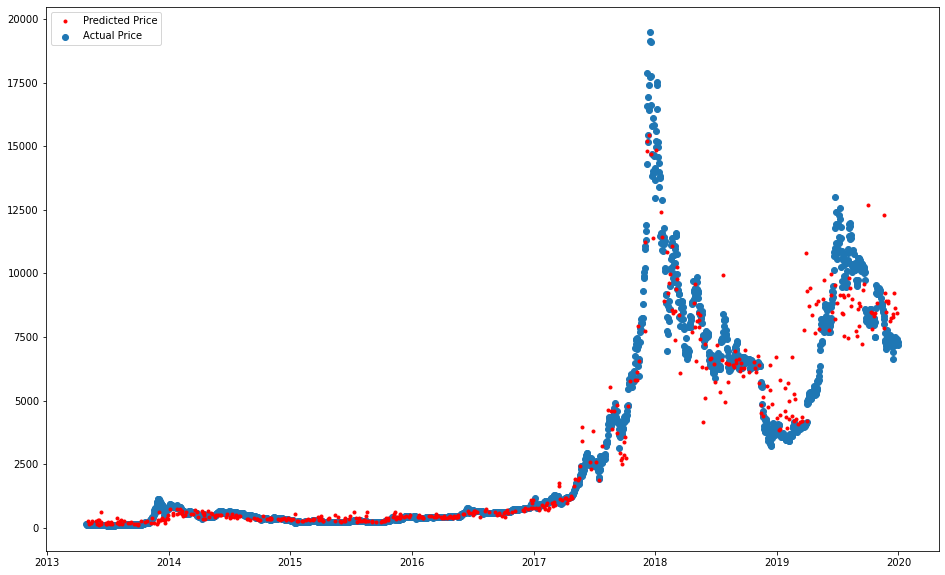

{'n_estimators': 288, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 30, 'bootstrap': True}


In [124]:
if __name__ == '__main__':
    main()

In [110]:
def random_forest_classification(df, out_dir):
    
    X = df.drop(['High', 'Low', 'Close', 'Open', 'Change'], axis=1)
    X = X.drop(['Marketcap'], axis=1)
    # X = X.drop(['Volume'], axis=1)
    y = df.Change
    dates = df.date
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20)
    
    
    train_dates = X_train.date
    valid_dates = X_valid.date
   
    
    X_train = X_train.drop('date', axis=1)
    X_valid = X_valid.drop('date', axis=1)
    
    
    
    
    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 100)]
    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(2, 30, num = 2)]
    max_depth.append(None)
    # Minimum number of samples required to split a node
    min_samples_split = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
    # Method of selecting samples for training each tree
    bootstrap = [True, False]
    # Create the random grid
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}

#     estimators = 300
#     depth = 7
#     split = 50
#     model = make_pipeline(
#             StandardScaler(),
#             RandomForestRegressor(n_estimators=estimators,
#             max_depth=depth , min_samples_split=split, min_samples_leaf=15)
#         )
#     model.fit(X_train, y_train)

#     pipe = make_pipeline(
#                 StandardScaler(),
#                 RandomForestRegressor()
#             )

    #print(X_train)
    #print(X_valid)
    #print(y_train)
    print(y_train.dtypes)
    
    rf = RandomForestClassifier()
    model = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
                                   n_iter = 30, cv = 5, verbose = 3, random_state=42, n_jobs = -1)
    
    model.fit(X_train, y_train)
    
    
    base_model = RandomForestClassifier(n_estimators = 10, random_state = 42)
    base_model.fit(X_train, y_train)
    #base_accuracy, predictions = evaluate(model, X_valid, y_valid)
    
    #best_random = model.best_estimator_
    #random_accuracy, predictions = evaluate(best_random, X_valid, y_valid)
    
    #print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

    #print('Evaluator Accuracy = %.5g' % (base_accuracy))
    print('valid data score=%.5g' % (model.score(X_valid, y_valid)))
    print('training data score=%.5g' % (model.score(X_train, y_train)))
    
    cm = confusion_matrix(y_valid, model.predict(X_valid), labels=None, sample_weight=None, normalize=None)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()

    plt.figure(figsize=(16, 10))
    
    plt.scatter(dates, y)
    plt.plot(valid_dates, model.predict(X_valid), 'r.')
    plt.show()
    #plt.savefig('{}/model_rfr.png'.format(out_dir))
    
    return model.best_params_, base_accuracy

In [86]:
def data_extract():
    response_API = requests.get('https://api.alternative.me/fng/?limit=0&format=csv')
    data = response_API


    dataset = data.text.splitlines()
    df = pd.DataFrame(dataset)
    df = df.drop(df.index[0:4])
    df.reset_index()
    df = df.drop(df.index[1395:])

    tmpDF = pd.DataFrame(columns=['date','index', 'fear'])
    tmpDF[['date','index','fear']] = df[0].str.split(',',expand=True)
    return tmpDF


In [ ]:

def boosted_regression(df, out_dir):
    
    X = df.drop(['High', 'Low', 'Close', 'Open', 'Change'], axis=1)
    X = X.drop(['Marketcap'], axis=1)
    # X = X.drop(['Volumn'], axis=1)

    y = df.Close
    dates = df.date
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25)
    
    train_dates = X_train.date
    valid_dates = X_valid.date
    
    X_train = X_train.drop('date', axis=1)
    X_valid = X_valid.drop('date', axis=1)
    
    estimators = 300
    depth = 10
    split = 25
    
    model = GradientBoostingRegressor(n_estimators=estimators,
            max_depth=depth , min_samples_split=split, min_samples_leaf=5)
    model.fit(X_train, y_train)
    print('valid data score=%.5g' % (model.score(X_valid, y_valid)))
    print('training data score=%.5g' % (model.score(X_train, y_train)))
    
    plt.figure(figsize=(8, 5))
    plt.scatter(dates, y)
    plt.plot(valid_dates, model.predict(X_valid), 'r.')
    plt.savefig('{}/model_br.png'.format(out_dir))

In [ ]:
def linear_regression(n, df, out_dir):
    
    X = df.drop(['High', 'Low', 'Close', 'Open', 'Change'], axis=1)
    X = X.drop(['Marketcap'], axis=1)
    # X = X.drop(['Volume'], axis=1)
    y = df.Close
    dates = df.date
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25)
    
    train_dates = X_train.date
    valid_dates = X_valid.date
    
    X_train = X_train.drop('date', axis=1)
    X_valid = X_valid.drop('date', axis=1)
    
    model = score_polyfit(n, X_train, y_train, X_valid, y_valid)
    
    plt.figure(figsize=(8, 5))
    plt.scatter(dates, y)
    plt.plot(valid_dates, model.predict(X_valid), 'r.')
    plt.show()
    #plt.savefig('{}/model_lr.png'.format(out_dir))
    

In [ ]:
def score_polyfit(n, X_train, y_train, X_valid, y_valid):
    
    model = make_pipeline(
        StandardScaler(),
        PolynomialFeatures(degree=n, include_bias=True),
        LinearRegression(fit_intercept=False)
    )
    
    model.fit(X_train, y_train)

    print('n={}: valid data score=%.5g'.format(n) % (model.score(X_valid, y_valid)))
    print('n={}: training data score=%.5g'.format(n) % (model.score(X_train, y_train)))
    
    return model

# Input: n <- degree of the polynomial
#       df <- dataframe to train
#  out_dir <- directory to store image